# Artefacts
> This notebook is used to create the artefacts for the GCN-ID 2024 dataset paper.

In [1]:
#| default_exp artefacts

In [2]:
#| eval: false
import os
import sys
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wildlife_tools.similarity import CosineSimilarity
from wildlife_datasets import analysis, datasets, splits
import pycocotools.mask as mask_util
from wildlife_tools.data import ImageDataset
from sklearn.metrics import average_precision_score
import numpy as np
import timm
from transformers import AutoModel
import torch
import numpy as np
from wildlife_tools.inference import TopkClassifier, KnnClassifier
from wildlife_tools.features import DeepFeatures
import torchvision.transforms as T
from PIL import Image
import kaggle
import pandas as pd
from wildlife_tools.data import ImageDataset, FeatureDataset, FeatureDatabase
from gcn_reid.segmentation import decode_rle_mask
from gcn_reid.newt_dataset import upload_to_kaggle
from pathlib import Path
from gcn_reid.newt_dataset import download_kaggle_dataset
from tqdm import tqdm
from transformers import AutoImageProcessor, AutoModel
import cv2
from IPython import display

2025-06-27 09:10:52.288711: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751015452.318989   12700 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751015452.328869   12700 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
dataset_name = 'mshahoyi/gcn-id-2024'
dataset_path = Path('data/gcn-id-2024')
download_kaggle_dataset(dataset_name, dataset_path)

Dataset already exists at data/gcn-id-2024


PosixPath('data/gcn-id-2024')

In [4]:
metadata = pd.read_csv(dataset_path / 'metadata.csv')
metadata

,reference_id,file_path,file_name,is_video,identity,creation_date,bbox,segmentation_mask_rle,is_hard_test_query,is_hard_val_query,is_least_similar_test_query,is_least_similar_val_query,is_random_test_query,is_random_val_query
0,GCN34-P3-S2,newts/1/IMG_2532.JPEG,IMG_2532.JPEG,False,1,2024-05-10 08:37:21+00:00,"[14.939163208007812, 507.19061279296875, 1066....",2048x1536:Sd`03ko14N0000000bNKcRN0^O5om1KcRN1]...,NaN,False,NaN,NaN,True,NaN
1,GCN34-P3-S2,newts/1/IMG_2530.JPEG,IMG_2530.JPEG,False,1,2024-05-10 08:37:19+00:00,"[288.80975341796875, 363.1075439453125, 1062.7...",2048x1536:[ajb03;31K_n1:YQN10O4Knm1h0lQN_O2O0M...,NaN,False,NaN,NaN,False,NaN
2,GCN34-P3-S2,newts/1/IMG_2531.JPEG,IMG_2531.JPEG,False,1,2024-05-10 08:37:20+00:00,"[288.86181640625, 521.5284423828125, 1159.4096...",2048x1536:Pcdb07^o1d0D7H=E5K5L5J5K3M4M3M10001N...,NaN,False,NaN,NaN,False,NaN
3,GCN34-P3-S2,newts/1/IMG_2533.JPEG,IMG_2533.JPEG,False,1,2024-05-10 08:37:23+00:00,"[489.2838134765625, 169.9361572265625, 1132.72...",2048x1536:X`Vo06do1;H;dNH]RN>[m1e1]O5M4K4M3M3L...,NaN,False,NaN,NaN,False,NaN
4,GCN34-P3-S2,newts/1/IMG_2534.JPEG,IMG_2534.JPEG,False,1,2024-05-10 08:37:24+00:00,"[365.6585388183594, 454.51068115234375, 1005.9...",2048x1536:SmZd03lo13M3M2O1O1N2`QNJTm16gRN3Vm1M...,NaN,True,NaN,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2460,GCN2-P4-S6,newts/206/IMG_3588.JPEG,IMG_3588.JPEG,False,206,2024-06-07 08:13:15+00:00,"[497.18017578125, 333.2651062011719, 1013.9716...",2046x1538:Zido07bo17M2M2N2N2O1O1N2O1O0O2O1N2O1...,NaN,NaN,NaN,NaN,NaN,NaN
2461,GCN2-P4-S6,newts/206/IMG_3583.MOV,IMG_3583.MOV,True,206,2024-06-07 14:48:31+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2462,GCN2-P4-S6,newts/206/IMG_3583.JPEG,IMG_3583.JPEG,False,206,2024-06-07 08:13:06+00:00,"[3.999234437942505, 593.5800170898438, 1326.80...",2046x1538:Z[1>6`1Vm1`NjRN`1Vm1`NjRN`1Um1h0L6J5...,NaN,NaN,NaN,NaN,NaN,NaN
2463,GCN2-P4-S6,newts/206/IMG_3588.MOV,IMG_3588.MOV,True,206,2024-06-07 14:48:27+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
artifacts_path = Path('artifacts')

In [6]:
dino_features_df = pd.read_csv(artifacts_path / 'metadata_with_features.csv')
dino_features_df['dinov2_features'] = dino_features_df['dinov2_features'].apply(eval)
dino_features_df

,reference_id,file_path,file_name,is_video,identity,creation_date,bbox,segmentation_mask_rle,dinov2_features
0,GCN34-P3-S2,newts/1/IMG_2532.JPEG,IMG_2532.JPEG,False,1,2024-05-10 08:37:21+00:00,"[14.939163208007812, 507.19061279296875, 1066....",2048x1536:Sd`03ko14N0000000bNKcRN0^O5om1KcRN1]...,"[0.15917837619781494, 1.008996844291687, -3.47..."
1,GCN34-P3-S2,newts/1/IMG_2530.JPEG,IMG_2530.JPEG,False,1,2024-05-10 08:37:19+00:00,"[288.80975341796875, 363.1075439453125, 1062.7...",2048x1536:[ajb03;31K_n1:YQN10O4Knm1h0lQN_O2O0M...,"[0.2540416121482849, -0.6189689636230469, -2.4..."
2,GCN34-P3-S2,newts/1/IMG_2531.JPEG,IMG_2531.JPEG,False,1,2024-05-10 08:37:20+00:00,"[288.86181640625, 521.5284423828125, 1159.4096...",2048x1536:Pcdb07^o1d0D7H=E5K5L5J5K3M4M3M10001N...,"[-0.3387486934661865, -0.4380609393119812, -1...."
3,GCN34-P3-S2,newts/1/IMG_2533.JPEG,IMG_2533.JPEG,False,1,2024-05-10 08:37:23+00:00,"[489.2838134765625, 169.9361572265625, 1132.72...",2048x1536:X`Vo06do1;H;dNH]RN>[m1e1]O5M4K4M3M3L...,"[1.2573355436325073, 0.47167059779167175, -1.6..."
4,GCN34-P3-S2,newts/1/IMG_2534.JPEG,IMG_2534.JPEG,False,1,2024-05-10 08:37:24+00:00,"[365.6585388183594, 454.51068115234375, 1005.9...",2048x1536:SmZd03lo13M3M2O1O1N2`QNJTm16gRN3Vm1M...,"[0.5498214960098267, -0.217705637216568, -1.48..."
...,...,...,...,...,...,...,...,...,...
1227,GCN2-P4-S6,newts/206/IMG_3584.JPEG,IMG_3584.JPEG,False,206,2024-06-07 08:13:07+00:00,"[3.784446954727173, 689.7179565429688, 1264.17...",2046x1538:Qc1=ao1000NU1lPN^Oik1GnSNn2\k1o0L3L2...,"[0.47062012553215027, -0.17789024114608765, 0...."
1228,GCN2-P4-S6,newts/206/IMG_3587.JPEG,IMG_3587.JPEG,False,206,2024-06-07 08:13:14+00:00,"[533.1634521484375, 384.0157165527344, 1025.15...",2046x1538:ggjQ19co13M3M2O1N2N2N1O2O1N2O001N2N1...,"[1.1572446823120117, 0.08006935566663742, -1.5..."
1229,GCN2-P4-S6,newts/206/IMG_3586.JPEG,IMG_3586.JPEG,False,206,2024-06-07 08:13:11+00:00,"[3.742919683456421, 945.6688842773438, 1264.32...",2046x1538:ld7:`o1m0SO:I4M2M3N1N10001O001O0O100...,"[-0.28730177879333496, -1.254452109336853, -1...."
1230,GCN2-P4-S6,newts/206/IMG_3588.JPEG,IMG_3588.JPEG,False,206,2024-06-07 08:13:15+00:00,"[497.18017578125, 333.2651062011719, 1013.9716...",2046x1538:Zido07bo17M2M2N2N2O1O1N2O1O0O2O1N2O1...,"[0.8618399500846863, 0.15614207088947296, -2.5..."


In [7]:
deep_features_df = pd.read_csv(artifacts_path/'baseline_features.csv')

deep_features_df['mega_features'] = deep_features_df['mega_features'].apply(eval)
deep_features_df['miewid_features'] = deep_features_df['miewid_features'].apply(eval)
deep_features_df['mega_features_cropped'] = deep_features_df['mega_features_cropped'].apply(eval)
deep_features_df['miewid_features_cropped'] = deep_features_df['miewid_features_cropped'].apply(eval)
deep_features_df['mega_features_cropped_rotated'] = deep_features_df['mega_features_cropped_rotated'].apply(eval)
deep_features_df['miewid_features_cropped_rotated'] = deep_features_df['miewid_features_cropped_rotated'].apply(eval)
deep_features_df['mega_features_rotated'] = deep_features_df['mega_features_rotated'].apply(eval)
deep_features_df['miewid_features_rotated'] = deep_features_df['miewid_features_rotated'].apply(eval)
deep_features_df

,reference_id,path,image_name,is_video,identity,creation_date,bbox,segmentation_mask_rle,is_hard_test_query,is_hard_val_query,...,is_random_test_query,is_random_val_query,mega_features,miewid_features,mega_features_cropped,miewid_features_cropped,mega_features_cropped_rotated,miewid_features_cropped_rotated,mega_features_rotated,miewid_features_rotated
0,GCN34-P3-S2,newts/1/IMG_2532.JPEG,IMG_2532.JPEG,False,1,2024-05-10 08:37:21+00:00,"[14.939163208007812, 507.19061279296875, 1066....",2048x1536:Sd`03ko14N0000000bNKcRN0^O5om1KcRN1]...,NaN,False,...,True,NaN,"[-0.2315349131822586, -0.6071900129318237, 0.2...","[-1.0500768423080444, 0.9018495678901672, 1.10...","[-0.26754456758499146, -0.3176382780075073, -0...","[-0.9890046119689941, -0.3878686726093292, 0.0...","[-0.09139543771743774, -0.27838510274887085, -...","[-2.282212018966675, -1.1495726108551025, 0.36...","[0.03521648794412613, -0.27079200744628906, 0....","[-0.6298500895500183, 1.3818387985229492, 0.42..."
1,GCN34-P3-S2,newts/1/IMG_2530.JPEG,IMG_2530.JPEG,False,1,2024-05-10 08:37:19+00:00,"[288.80975341796875, 363.1075439453125, 1062.7...",2048x1536:[ajb03;31K_n1:YQN10O4Knm1h0lQN_O2O0M...,NaN,False,...,False,NaN,"[-0.26202958822250366, -0.36001867055892944, 0...","[-0.7708876729011536, -0.0288423839956522, 2.0...","[-0.1098005622625351, -0.8450853824615479, -0....","[-0.9856569766998291, 0.9584597945213318, 0.01...","[0.07837007194757462, -0.1861935257911682, 0.1...","[-0.7282273769378662, 1.7479289770126343, 1.67...","[0.11916843801736832, -0.4386592507362366, 0.3...","[0.30683621764183044, -0.7263781428337097, 1.2..."
2,GCN34-P3-S2,newts/1/IMG_2531.JPEG,IMG_2531.JPEG,False,1,2024-05-10 08:37:20+00:00,"[288.86181640625, 521.5284423828125, 1159.4096...",2048x1536:Pcdb07^o1d0D7H=E5K5L5J5K3M4M3M10001N...,NaN,False,...,False,NaN,"[-0.10255614668130875, -0.5083745718002319, 0....","[-2.023824453353882, 1.434230089187622, 1.3461...","[0.23407597839832306, -0.5330269932746887, -0....","[-0.4053780734539032, 1.5312628746032715, 0.22...","[0.010707120411098003, -0.2526978552341461, 0....","[0.07896972447633743, -0.052093833684921265, -...","[0.4626787602901459, -0.20769257843494415, 0.2...","[0.3217676877975464, -0.014798182062804699, 0...."
3,GCN34-P3-S2,newts/1/IMG_2533.JPEG,IMG_2533.JPEG,False,1,2024-05-10 08:37:23+00:00,"[489.2838134765625, 169.9361572265625, 1132.72...",2048x1536:X`Vo06do1;H;dNH]RN>[m1e1]O5M4K4M3M3L...,NaN,False,...,False,NaN,"[0.08337608724832535, -0.6282830834388733, 0.7...","[-0.5282672047615051, 0.8011835813522339, 3.37...","[-0.23315174877643585, -0.11018437892198563, 0...","[-1.0730949640274048, -1.6122236251831055, -0....","[-0.11565772444009781, -0.22544527053833008, -...","[-2.143435001373291, 0.8045357465744019, -0.56...","[0.2420016974210739, -0.21130432188510895, 0.1...","[-0.7259004712104797, 0.5267841219902039, 1.34..."
4,GCN34-P3-S2,newts/1/IMG_2534.JPEG,IMG_2534.JPEG,False,1,2024-05-10 08:37:24+00:00,"[365.6585388183594, 454.51068115234375, 1005.9...",2048x1536:SmZd03lo13M3M2O1O1N2`QNJTm16gRN3Vm1M...,NaN,True,...,False,NaN,"[-0.09542281180620193, -0.17980623245239258, 0...","[-1.5232231616973877, 1.9110876321792603, 0.73...","[0.028459327295422554, -0.3369773328304291, -0...","[-1.5894969701766968, 0.6951966285705566, 0.99...","[0.13891857862472534, -0.7412286400794983, -0....","[-1.5177595615386963, -0.8847625255584717, -0....","[-0.048625629395246506, -0.1544991135597229, 0...","[-1.8346766233444214, -1.370731234550476, -0.1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,GCN7-P3-S6,newts/202/IMG_3618.JPEG,IMG_3618.JPEG,False,202,2024-06-07 08:17:00+00:00,"[173.46243286132812, 251.09988403320312, 1007....",2046x1538:]UV;2m18ek14RSNJ_O159;@8:j0KRe10^YN2...,False,NaN,...,NaN,NaN,"[0.36045947670936584, -0.4749039113521576, -0....","[0.7483136057853699, -0.9030152559280396, -0.4...","[-0.004413387272506952, 0.20352308452129364, -...","[1.0502841472625732, -0.22691012918949127, 3.3...","[0.1868

# Output least similar images

In [8]:
dinov2_features = np.array(dino_features_df['dinov2_features'].tolist())

In [9]:
# Calculate cosine similarities manually
def cosine_similarity(a, b):
    # Normalize the vectors
    a_norm = a / np.linalg.norm(a, axis=1)[:, np.newaxis]
    b_norm = b / np.linalg.norm(b, axis=1)[:, np.newaxis]
    # Calculate similarity matrix
    return np.dot(a_norm, b_norm.T)

dinov2_similarities = cosine_similarity(dinov2_features, dinov2_features)

dinov2_similarities.shape

(1232, 1232)

In [10]:
# Here I will create a dataframe of all similarities for each image
dino_features_df['id_and_image_name'] = dino_features_df['identity'].astype(str) + '_' + dino_features_df['file_name']
dino_features_df['id_and_image_name']

0         1_IMG_2532.JPEG
1         1_IMG_2530.JPEG
2         1_IMG_2531.JPEG
3         1_IMG_2533.JPEG
4         1_IMG_2534.JPEG
              ...        
1227    206_IMG_3584.JPEG
1228    206_IMG_3587.JPEG
1229    206_IMG_3586.JPEG
1230    206_IMG_3588.JPEG
1231    206_IMG_3583.JPEG
Name: id_and_image_name, Length: 1232, dtype: object

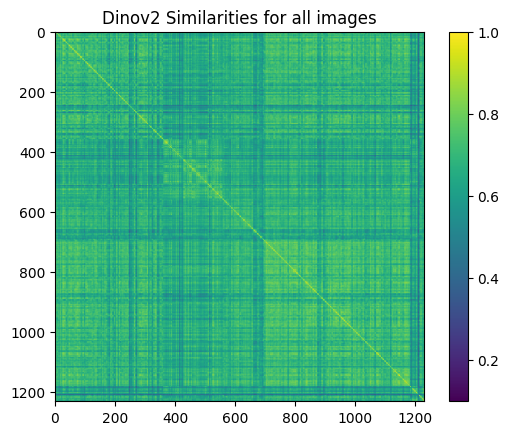

In [11]:
dinov2_similarities_df = pd.DataFrame(dinov2_similarities, index=dino_features_df['id_and_image_name'], columns=dino_features_df['id_and_image_name'])
plt.imshow(dinov2_similarities_df.to_numpy())
plt.title('Dinov2 Similarities for all images')
plt.colorbar()
plt.show()

In [12]:
dinov2_similarities_df.to_csv(artifacts_path/'dinov2_similarities.csv')
dinov2_similarities_df

id_and_image_name,1_IMG_2532.JPEG,1_IMG_2530.JPEG,1_IMG_2531.JPEG,1_IMG_2533.JPEG,1_IMG_2534.JPEG,2_IMG_2524.JPEG,2_IMG_2527.JPEG,2_IMG_2526.JPEG,2_IMG_2525.JPEG,2_IMG_2528.JPEG,...,205_IMG_3581.JPEG,205_IMG_3577.JPEG,205_IMG_3580.JPEG,205_IMG_3578.JPEG,206_IMG_3585.JPEG,206_IMG_3584.JPEG,206_IMG_3587.JPEG,206_IMG_3586.JPEG,206_IMG_3588.JPEG,206_IMG_3583.JPEG
id_and_image_name,,,,,,,,,,,,,,,,,,,,,
1_IMG_2532.JPEG,1.000000,0.813332,0.879888,0.850998,0.813479,0.746874,0.724935,0.698625,0.748820,0.658164,...,0.688525,0.690578,0.676408,0.703017,0.675177,0.708753,0.700074,0.746665,0.691813,0.696542
1_IMG_2530.JPEG,0.813332,1.000000,0.833461,0.800902,0.729356,0.712115,0.643013,0.600463,0.681778,0.600570,...,0.643940,0.620823,0.631780,0.622667,0.587712,0.626577,0.633139,0.629304,0.635964,0.604534
1_IMG_2531.JPEG,0.879888,0.833461,1.000000,0.834979,0.795149,0.716890,0.702605,0.676005,0.727538,0.634601,...,0.649514,0.656397,0.624289,0.644107,0.615615,0.644176,0.651721,0.665901,0.653605,0.621452
1_IMG_2533.JPEG,0.850998,0.800902,0.834979,1.000000,0.780088,0.756950,0.668114,0.640386,0.732097,0.651160,...,0.720670,0.660763,0.692657,0.700327,0.623296,0.650449,0.690462,0.675733,0.657201,0.654708
1_IMG_2534.JPEG,0.813479,0.729356,0.795149,0.780088,1.000000,0.730636,0.732146,0.680611,0.724181,0.726167,...,0.659030,0.687106,0.637938,0.700483,0.691518,0.664188,0.651867,0.697254,0.614804,0.670923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206_IMG_3584.JPEG,0.708753,0.626577,0.644176,0.650449,0.664188,0.714146,0.699209,0.687429,0.745159,0.673599,...,0.763114,0.734511,0.755917,0.751901,0.939096,1.000000,0.813961,0.878643,0.767568,0.918880
206_IMG_3587.JPEG,0.700074,0.633139,0.651721,0.690462,0.651867,0.718811,0.668693,0.631837,0.700078,0.622394,...,0.746712,0.684394,0.755745,0.752171,0.788080,0.813961,1.000000,0.836224,0.913911,0.806955
206_IMG_3586.JPEG,0.746665,0.629304,0.665901,0.675733,0.697254,0.740875,0.724477,0.713933,0.735753,0.667181,...,0.769256,0.732786,0.786979,0.786723,0.869043,0.878643,0.836224,1.000000,0.782906,0.882148


In [13]:

def plot_identity_similarities(identity, dino_features_df, dinov2_similarities, dataset_path):
    """Plot all images for a given identity with their similarity scores.
    
    Args:
        identity: The identity ID to plot
        dino_features_df: DataFrame containing image features and metadata
        dinov2_similarities: Matrix of similarity scores between all images
        dataset_path: Path to the dataset containing the images
    """
    identity_df = dino_features_df[dino_features_df['identity'] == identity]

    n_images = len(identity_df)
    n_cols = n_images
    n_rows = (n_images + n_cols - 1) // n_cols

    plt.figure(figsize=(3*n_cols, 5*n_rows))

    for idx, (_, row) in enumerate(identity_df.iterrows()):
        # Get similarities for this image with other images of same identity
        image_idx = dino_features_df[dino_features_df['file_name'] == row['file_name']].index[0]
        similarities = dinov2_similarities[image_idx]
        
        # Get max similarity with other images of same identity (excluding self)
        same_identity_mask = (dino_features_df['identity'] == identity) & (dino_features_df['file_name'] != row['file_name'])
        if same_identity_mask.any():
            max_similarity = np.max(similarities[same_identity_mask])
        else:
            max_similarity = 0.0

        # Plot image
        plt.subplot(n_rows, n_cols, idx + 1)
        img = plt.imread(dataset_path/row['file_path'])
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        
        # Get name of most similar image
        if same_identity_mask.any():
            most_similar_idx = np.argmax(similarities[same_identity_mask])
            most_similar_name = dino_features_df.loc[same_identity_mask, 'file_name'].iloc[most_similar_idx]
            plt.title(f'Max similarity: {max_similarity:.3f}\nwith {most_similar_name}')
        else:
            plt.title(f'Max similarity: {max_similarity:.3f}\nNo other images')
        plt.xlabel(row['file_name'])

    plt.suptitle(f'Images for identity {identity}', fontsize=16)
    plt.tight_layout()

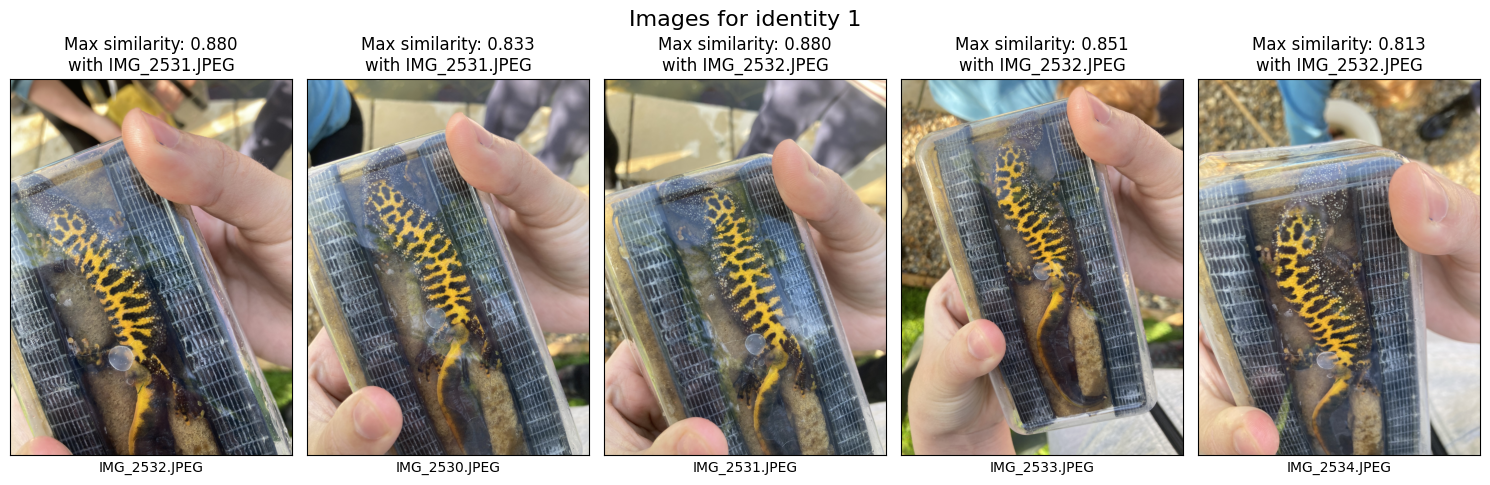

In [14]:
identity = dino_features_df['identity'].iloc[0]
plot_identity_similarities(identity, dino_features_df, dinov2_similarities, dataset_path)

In [15]:
dinov2_similarities_df.loc[dinov2_similarities_df.index.str.startswith('1_'), dinov2_similarities_df.columns.str.startswith('1_')]

id_and_image_name,1_IMG_2532.JPEG,1_IMG_2530.JPEG,1_IMG_2531.JPEG,1_IMG_2533.JPEG,1_IMG_2534.JPEG
id_and_image_name,,,,,
1_IMG_2532.JPEG,1.000000,0.813332,0.879888,0.850998,0.813479
1_IMG_2530.JPEG,0.813332,1.000000,0.833461,0.800902,0.729356
1_IMG_2531.JPEG,0.879888,0.833461,1.000000,0.834979,0.795149
1_IMG_2533.JPEG,0.850998,0.800902,0.834979,1.000000,0.780088
1_IMG_2534.JPEG,0.813479,0.729356,0.795149,0.780088,1.000000


In [16]:
n_images = 4

image_counts = dino_features_df.groupby('identity').file_name.count()
identities_with_n_images = image_counts[image_counts == n_images].index.tolist()
intra_identity_similarities_path = artifacts_path / 'intra_identity_similarities'
intra_identity_similarities_path.mkdir(parents=True, exist_ok=True)

for identity in identities_with_n_images:
    plot_identity_similarities(identity, dino_features_df, dinov2_similarities, dataset_path)
    plt.savefig(intra_identity_similarities_path / f'identity_{identity}_similarities.png')
    plt.close()
    df = dinov2_similarities_df.loc[dinov2_similarities_df.index.str.startswith(f'{identity}_'), dinov2_similarities_df.columns.str.startswith(f'{identity}_')]
    df.to_csv(intra_identity_similarities_path / f'identity_{identity}_similarities.csv')
    
    # Preview the similarity matrix for this identity
    display.display(df.style.background_gradient(cmap='RdYlBu', vmin=-1, vmax=1)
              .format("{:.3f}")
              .set_caption(f"Similarity matrix for identity {identity}"))

id_and_image_name,38_IMG_2505.JPEG,38_IMG_2502.JPEG,38_IMG_2503.JPEG,38_IMG_2501.JPEG
id_and_image_name,,,,
38_IMG_2505.JPEG,1.000,0.739,0.897,0.812
38_IMG_2502.JPEG,0.739,1.000,0.771,0.721
38_IMG_2503.JPEG,0.897,0.771,1.000,0.821
38_IMG_2501.JPEG,0.812,0.721,0.821,1.000


id_and_image_name,121_IMG_3236.JPEG,121_IMG_3235.JPEG,121_IMG_3237.JPEG,121_IMG_3238.JPEG
id_and_image_name,,,,
121_IMG_3236.JPEG,1.000,0.842,0.749,0.849
121_IMG_3235.JPEG,0.842,1.000,0.892,0.854
121_IMG_3237.JPEG,0.749,0.892,1.000,0.796
121_IMG_3238.JPEG,0.849,0.854,0.796,1.000


id_and_image_name,172_IMG_3359.JPEG,172_IMG_3358.JPEG,172_IMG_3356.JPEG,172_IMG_3357.JPEG
id_and_image_name,,,,
172_IMG_3359.JPEG,1.000,0.872,0.779,0.818
172_IMG_3358.JPEG,0.872,1.000,0.822,0.830
172_IMG_3356.JPEG,0.779,0.822,1.000,0.890
172_IMG_3357.JPEG,0.818,0.830,0.890,1.000


id_and_image_name,190_IMG_3647.JPEG,190_IMG_3649.JPEG,190_IMG_3646.JPEG,190_IMG_3648.JPEG
id_and_image_name,,,,
190_IMG_3647.JPEG,1.000,0.838,0.845,0.773
190_IMG_3649.JPEG,0.838,1.000,0.828,0.816
190_IMG_3646.JPEG,0.845,0.828,1.000,0.780
190_IMG_3648.JPEG,0.773,0.816,0.780,1.000


id_and_image_name,191_IMG_3663.JPEG,191_IMG_3664.JPEG,191_IMG_3665.JPEG,191_IMG_3662.JPEG
id_and_image_name,,,,
191_IMG_3663.JPEG,1.000,0.792,0.728,0.749
191_IMG_3664.JPEG,0.792,1.000,0.865,0.784
191_IMG_3665.JPEG,0.728,0.865,1.000,0.790
191_IMG_3662.JPEG,0.749,0.784,0.790,1.000


id_and_image_name,195_IMG_3658.JPEG,195_IMG_3657.JPEG,195_IMG_3659.JPEG,195_IMG_3660.JPEG
id_and_image_name,,,,
195_IMG_3658.JPEG,1.000,0.822,0.801,0.834
195_IMG_3657.JPEG,0.822,1.000,0.815,0.821
195_IMG_3659.JPEG,0.801,0.815,1.000,0.830
195_IMG_3660.JPEG,0.834,0.821,0.830,1.000


id_and_image_name,198_IMG_3613.JPEG,198_IMG_3611.JPEG,198_IMG_3612.JPEG,198_IMG_3610.JPEG
id_and_image_name,,,,
198_IMG_3613.JPEG,1.000,0.820,0.857,0.880
198_IMG_3611.JPEG,0.820,1.000,0.873,0.863
198_IMG_3612.JPEG,0.857,0.873,1.000,0.818
198_IMG_3610.JPEG,0.880,0.863,0.818,1.000


id_and_image_name,201_IMG_3623.JPEG,201_IMG_3624.JPEG,201_IMG_3622.JPEG,201_IMG_3625.JPEG
id_and_image_name,,,,
201_IMG_3623.JPEG,1.000,0.962,0.915,0.885
201_IMG_3624.JPEG,0.962,1.000,0.940,0.873
201_IMG_3622.JPEG,0.915,0.940,1.000,0.850
201_IMG_3625.JPEG,0.885,0.873,0.850,1.000
